In [1]:
# Required Libraries
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the Metadata
metadata_path = "/content/drive/MyDrive/ESC-50-master/meta/esc50.csv"
data = pd.read_csv(metadata_path)



In [4]:
# Display basic metadata info
print("Dataset Overview:")
print(data.head())
print("\nDataset Summary:")
print(data.info())

Dataset Overview:
            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2000 non-null   object
 1   fold      2000 non-null   int64 
 2   target    2000 non-null   int64 
 3   category  2000 non-null   object
 4   esc10     2000 non-null   bool  
 5   src_file  2000 non-null   int64 
 6   take      2000 non-null   object
dtypes: bool(1), int64(3), object(3)
memory usage: 95.8+ KB
None


In [5]:
# Check for missing values
print("\nMissing Values:\n", data.isnull().sum())





Missing Values:
 filename    0
fold        0
target      0
category    0
esc10       0
src_file    0
take        0
dtype: int64


In [6]:
# Count the number of samples per category
category_counts = data['category'].value_counts()

<ipython-input-7-4b90ae948424>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")


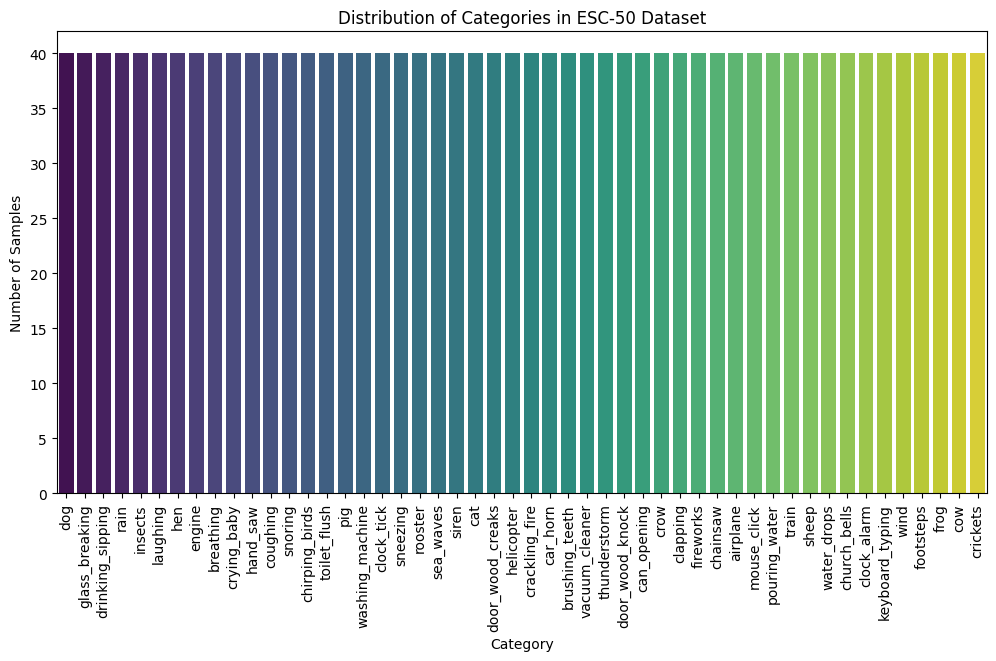

In [7]:
# Plotting the distribution of categories
plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Distribution of Categories in ESC-50 Dataset")
plt.ylabel("Number of Samples")
plt.xlabel("Category")
plt.show()





In [8]:
# Audio File Path
audio_dir = "/content/drive/MyDrive/ESC-50-master/audio"

# Function to extract features from an audio file
def extract_audio_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    rms = librosa.feature.rms(y=y).mean()
    zcr = librosa.feature.zero_crossing_rate(y=y).mean()
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()
    return {"Duration": duration, "RMS": rms, "ZCR": zcr, "Spectral Centroid": spectral_centroid}

In [9]:
# Extract features for a few samples (time-intensive for the full dataset)
sample_files = data.sample(5)  # Analyze 5 random samples
features = []

for _, row in sample_files.iterrows():
    file_path = os.path.join(audio_dir, row['filename'])
    audio_features = extract_audio_features(file_path)
    audio_features['Category'] = row['category']
    features.append(audio_features)

# Convert to DataFrame for analysis
features_df = pd.DataFrame(features)
print("\nExtracted Features:\n", features_df)


Extracted Features:
    Duration       RMS       ZCR  Spectral Centroid       Category
0       5.0  0.211129  0.045801        2315.727022            cow
1       5.0  0.022260  0.077494        4027.784217  pouring_water
2       5.0  0.008217  0.046488        1352.381586   church_bells
3       5.0  0.022815  0.068246        3555.441146    can_opening
4       5.0  0.002848  0.339922        8731.835763    mouse_click


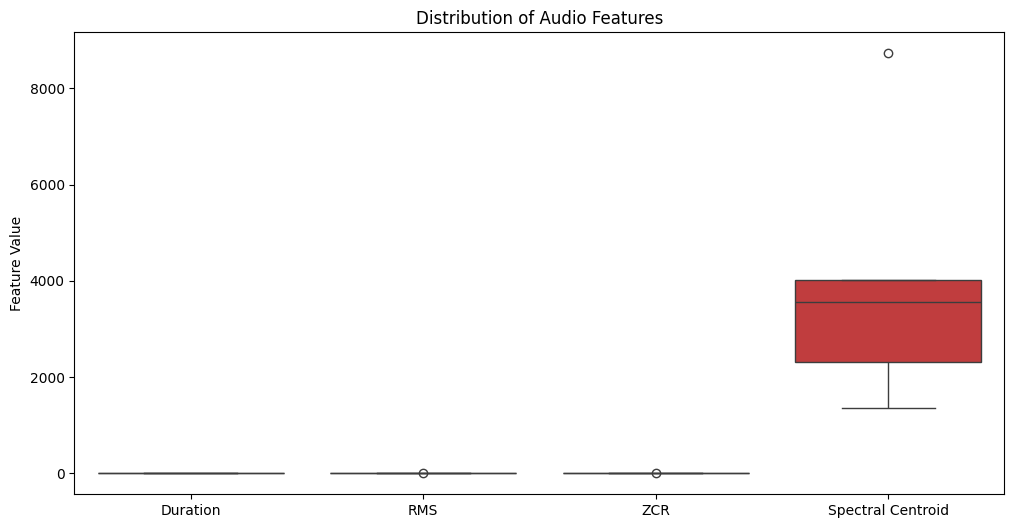

In [10]:

# Visualizing Audio Features
plt.figure(figsize=(12, 6))
sns.boxplot(data=features_df.drop(columns="Category"))
plt.title("Distribution of Audio Features")
plt.ylabel("Feature Value")
plt.show()




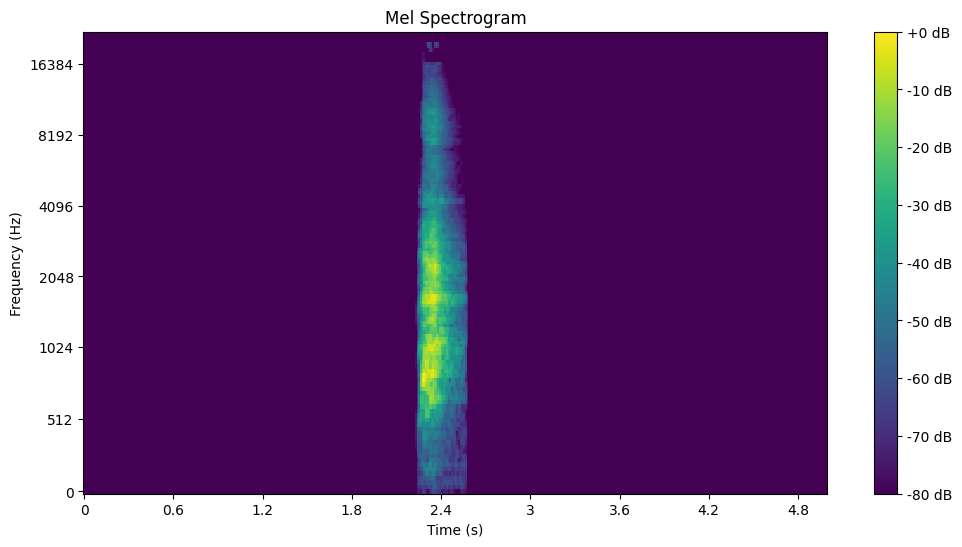

In [11]:
# Example: Visualizing Spectrogram of a Single File
sample_file = os.path.join(audio_dir, data.iloc[0]['filename'])
y, sr = librosa.load(sample_file, sr=None)
plt.figure(figsize=(12, 6))
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

# New Section

In [12]:
# Define categories of suspicious sounds
suspicious_categories = ["glass_breaking", "gun_shot", "screaming", "door_knock", "chainsaw"]

# Filter the dataset for suspicious sounds
suspicious_data = data[data['category'].isin(suspicious_categories)]

# Display the filtered dataset
print("Suspicious Sounds Dataset:")
print(suspicious_data)

# Save the filtered dataset to a CSV file (optional)
output_path = "suspicious_sounds.csv"
suspicious_data.to_csv(output_path, index=False)
print(f"Filtered dataset saved to: {output_path}")


Suspicious Sounds Dataset:
               filename  fold  target        category  esc10  src_file take
24    1-116765-A-41.wav     1      41        chainsaw   True    116765    A
92     1-19898-A-41.wav     1      41        chainsaw   True     19898    A
93     1-19898-B-41.wav     1      41        chainsaw   True     19898    B
94     1-19898-C-41.wav     1      41        chainsaw   True     19898    C
95     1-20133-A-39.wav     1      39  glass_breaking  False     20133    A
...                 ...   ...     ...             ...    ...       ...  ...
1880  5-233607-A-39.wav     5      39  glass_breaking  False    233607    A
1971  5-257642-A-39.wav     5      39  glass_breaking  False    257642    A
1979  5-260432-A-39.wav     5      39  glass_breaking  False    260432    A
1980  5-260433-A-39.wav     5      39  glass_breaking  False    260433    A
1981  5-260434-A-39.wav     5      39  glass_breaking  False    260434    A

[80 rows x 7 columns]
Filtered dataset saved to: suspicious_

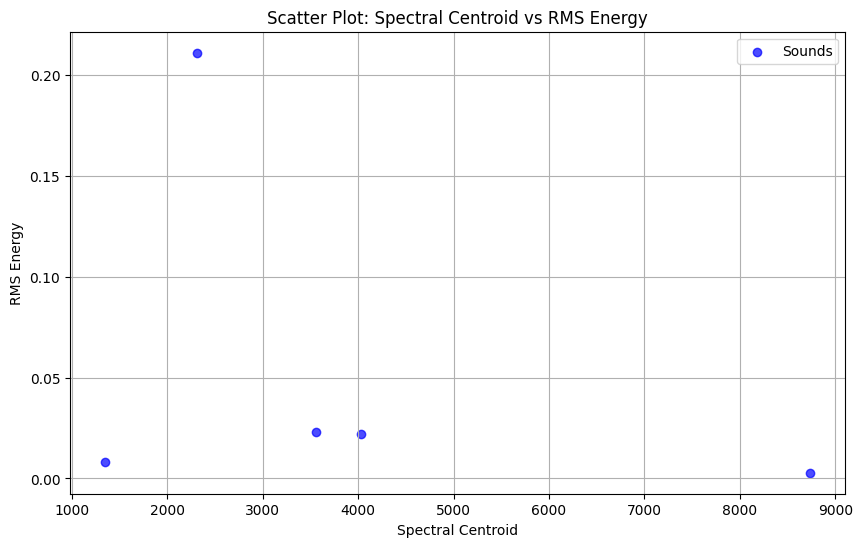

In [13]:


# Scatter Plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(features_df['Spectral Centroid'], features_df['RMS'], alpha=0.7, c='blue', label='Sounds')
plt.title("Scatter Plot: Spectral Centroid vs RMS Energy")
plt.xlabel("Spectral Centroid")
plt.ylabel("RMS Energy")
plt.legend()
plt.grid(True)
plt.show()




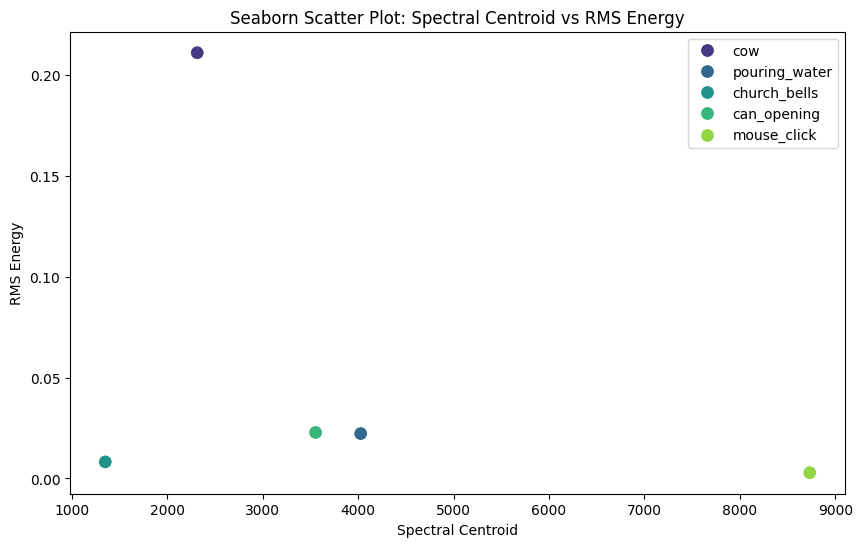

In [14]:
# Scatter Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=features_df, x='Spectral Centroid', y='RMS', hue='Category', palette='viridis', s=100)
plt.title("Seaborn Scatter Plot: Spectral Centroid vs RMS Energy")
plt.xlabel("Spectral Centroid")
plt.ylabel("RMS Energy")
plt.legend(loc='upper right')
plt.show()

Classification Report:
                precision    recall  f1-score   support

      chainsaw       0.90      0.90      0.90        10
glass_breaking       0.83      0.83      0.83         6

      accuracy                           0.88        16
     macro avg       0.87      0.87      0.87        16
  weighted avg       0.88      0.88      0.88        16



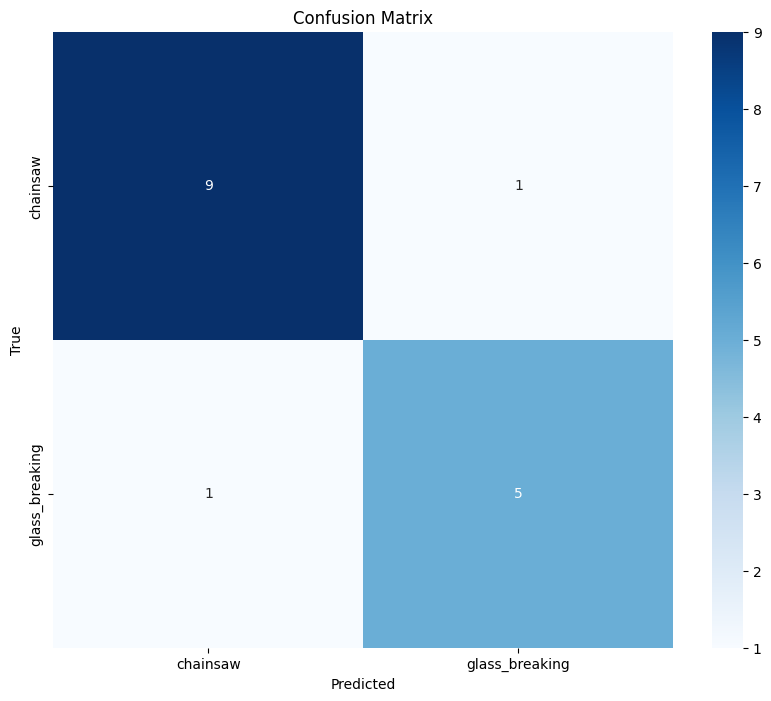

Classification Report:
                precision    recall  f1-score   support

      chainsaw       0.90      0.90      0.90        10
glass_breaking       0.83      0.83      0.83         6

      accuracy                           0.88        16
     macro avg       0.87      0.87      0.87        16
  weighted avg       0.88      0.88      0.88        16

Accuracy: 87.50%


In [15]:
#applying svm

# Define suspicious categories
suspicious_categories = ["glass_breaking", "gun_shot", "screaming", "door_knock", "chainsaw"]

# Load dataset metadata
metadata_path = "/content/drive/MyDrive/ESC-50-master/meta/esc50.csv"
data = pd.read_csv(metadata_path)

# Filter dataset for suspicious sounds
filtered_data = data[data['category'].isin(suspicious_categories)]

# Audio directory path
audio_dir = "/content/drive/MyDrive/ESC-50-master/audio"

# Function to extract audio features
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    features = {
        "RMS": librosa.feature.rms(y=y).mean(),
        "ZCR": librosa.feature.zero_crossing_rate(y=y).mean(),
        "Spectral Centroid": librosa.feature.spectral_centroid(y=y, sr=sr).mean(),
        "Spectral Bandwidth": librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    }
    return features

# Extract features for the filtered dataset
features = []
labels = []

for _, row in filtered_data.iterrows():
    file_path = os.path.join(audio_dir, row['filename'])
    audio_features = extract_features(file_path)
    features.append(audio_features)
    labels.append(row['category'])

# Convert to DataFrame
features_df = pd.DataFrame(features)
features_df['Label'] = labels

# Prepare feature matrix (X) and target labels (y)
X = features_df.drop(columns="Label")
y = features_df['Label']

# Encode target labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train an SVM Classifier
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Predict on the test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Calculate and display accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")





Classification Report:
                precision    recall  f1-score   support

      chainsaw       0.73      0.80      0.76        10
glass_breaking       0.60      0.50      0.55         6

      accuracy                           0.69        16
     macro avg       0.66      0.65      0.65        16
  weighted avg       0.68      0.69      0.68        16



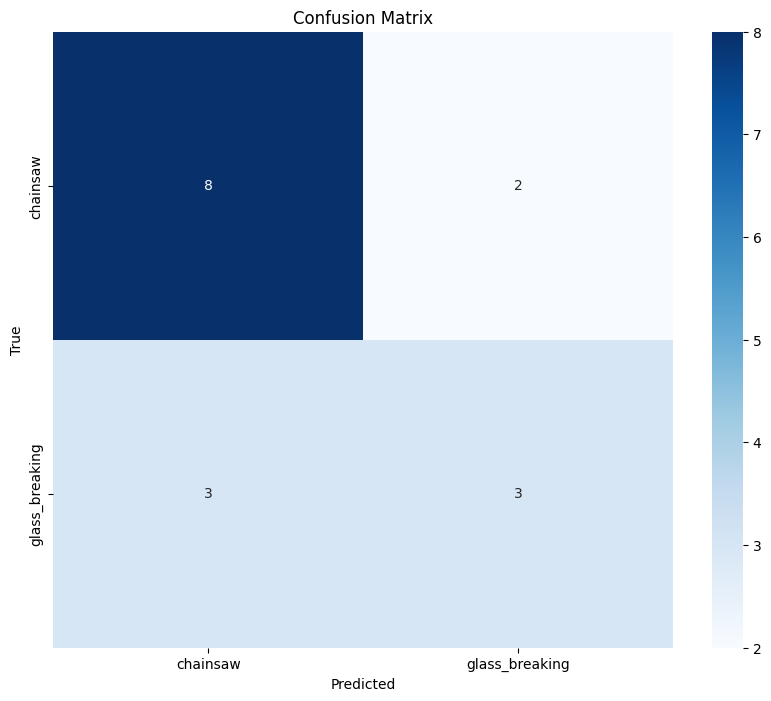

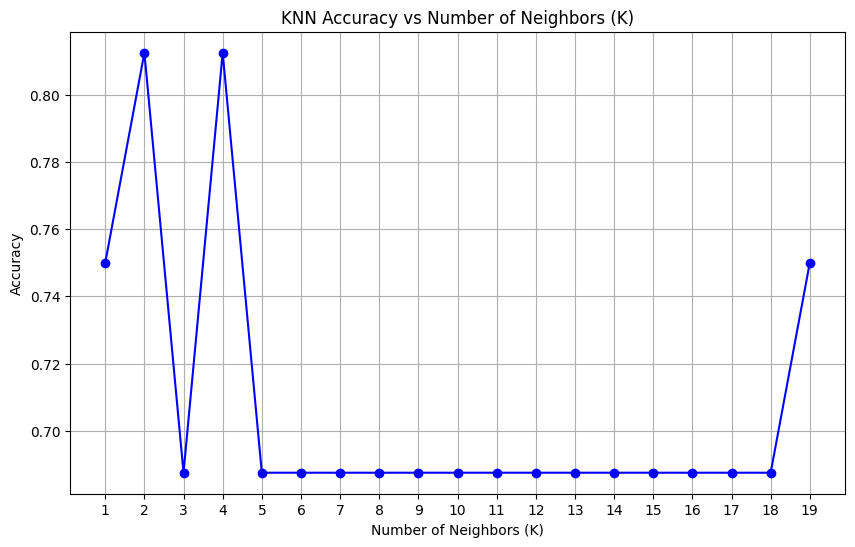

In [16]:
# Applying KNN

# Define suspicious categories
suspicious_categories = ["glass_breaking", "gun_shot", "screaming", "door_knock", "chainsaw"]

# Load dataset metadata
metadata_path = "/content/drive/MyDrive/ESC-50-master/meta/esc50.csv"
data = pd.read_csv(metadata_path)

# Filter dataset for suspicious sounds
filtered_data = data[data['category'].isin(suspicious_categories)]

# Audio directory path
audio_dir = "/content/drive/MyDrive/ESC-50-master/audio"

# Function to extract audio features
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    features = {
        "RMS": librosa.feature.rms(y=y).mean(),
        "ZCR": librosa.feature.zero_crossing_rate(y=y).mean(),
        "Spectral Centroid": librosa.feature.spectral_centroid(y=y, sr=sr).mean(),
        "Spectral Bandwidth": librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()
    }
    return features

# Extract features for the filtered dataset
features = []
labels = []

for _, row in filtered_data.iterrows():
    file_path = os.path.join(audio_dir, row['filename'])
    audio_features = extract_features(file_path)
    features.append(audio_features)
    labels.append(row['category'])

# Convert to DataFrame
features_df = pd.DataFrame(features)
features_df['Label'] = labels

# Prepare feature matrix (X) and target labels (y)
X = features_df.drop(columns="Label")
y = features_df['Label']

# Encode target labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train KNN Classifier
k = 5  # Number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, y_train)

# Predict on the test set
y_pred = knn_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plotting Accuracy vs K Value (Optional)
accuracy_list = []
for k in range(1, 20):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    accuracy = knn_model.score(X_test, y_test)
    accuracy_list.append(accuracy)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), accuracy_list, marker='o', linestyle='-', color='blue')
plt.title("KNN Accuracy vs Number of Neighbors (K)")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy")
plt.xticks(range(1, 20))
plt.grid()
plt.show()




Classification Report:
                precision    recall  f1-score   support

      chainsaw       0.90      0.90      0.90        10
glass_breaking       0.83      0.83      0.83         6

      accuracy                           0.88        16
     macro avg       0.87      0.87      0.87        16
  weighted avg       0.88      0.88      0.88        16

Accuracy: 87.50%


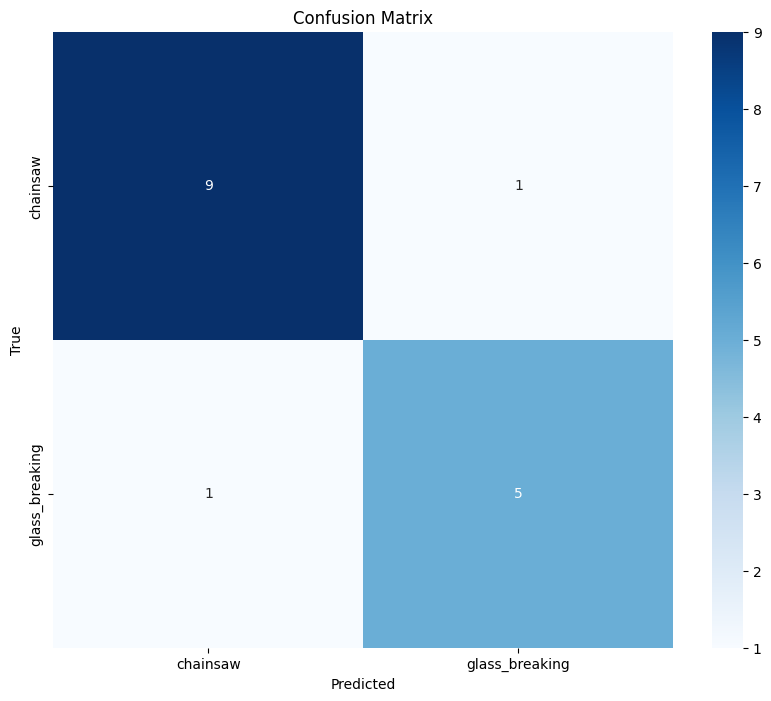

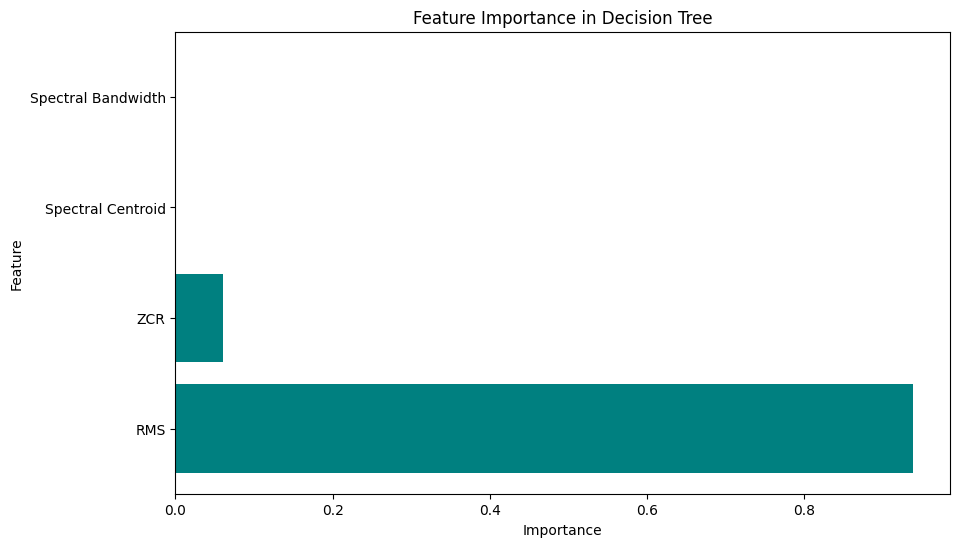

In [17]:
# Decision Tree

# Prepare the feature matrix (X) and target labels (y)
# Assuming 'X' (features) and 'y' (labels) are already prepared as shown in earlier steps.

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)  # Adjust max_depth if necessary
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Calculate and display accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
# Feature Importance
importances = dt_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances, color='teal')
plt.title("Feature Importance in Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()



Classification Report:
                precision    recall  f1-score   support

      chainsaw       0.90      0.90      0.90        10
glass_breaking       0.83      0.83      0.83         6

      accuracy                           0.88        16
     macro avg       0.87      0.87      0.87        16
  weighted avg       0.88      0.88      0.88        16

Accuracy: 87.50%


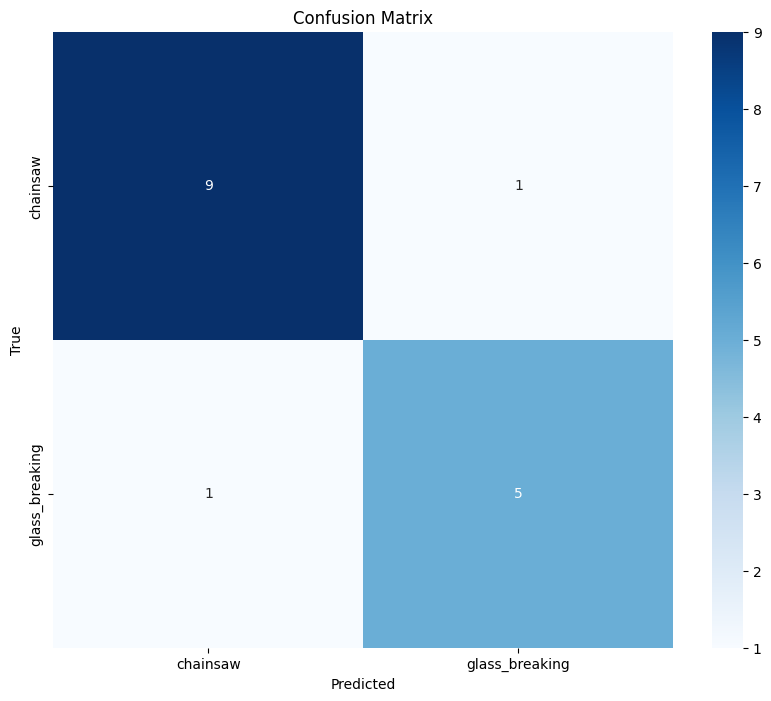

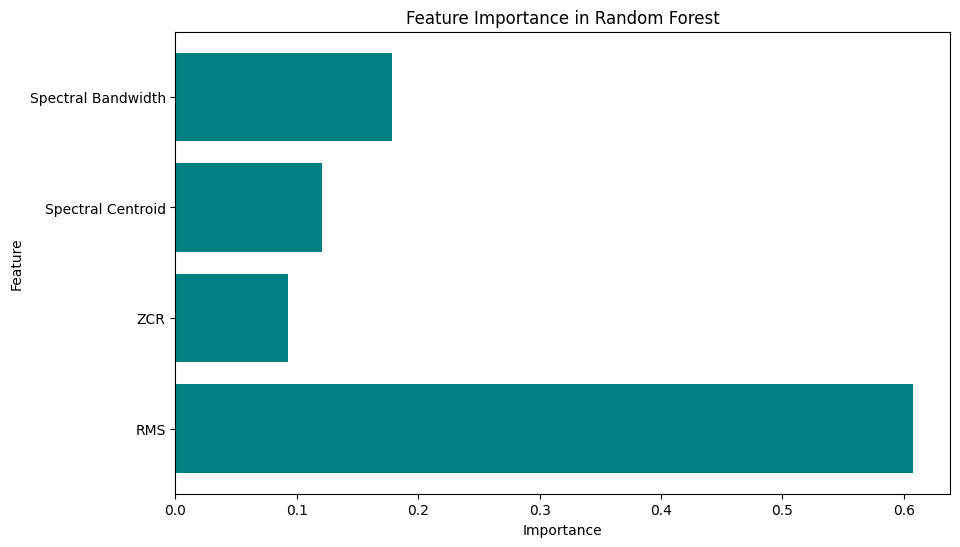

In [18]:
# RandomForestClassifier

# Prepare the feature matrix (X) and target labels (y)
# Assuming 'X' (features) and 'y' (labels) are already prepared as shown in earlier steps.

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Number of trees set to 100
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Calculate and display accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Feature Importance
importances = rf_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances, color='teal')
plt.title("Feature Importance in Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


Model Comparison Results:
           Model  Accuracy
0  Random Forest     87.50
1  Decision Tree     87.50
2            SVM     75.00
3            KNN     68.75


<ipython-input-19-230289588f3e>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")


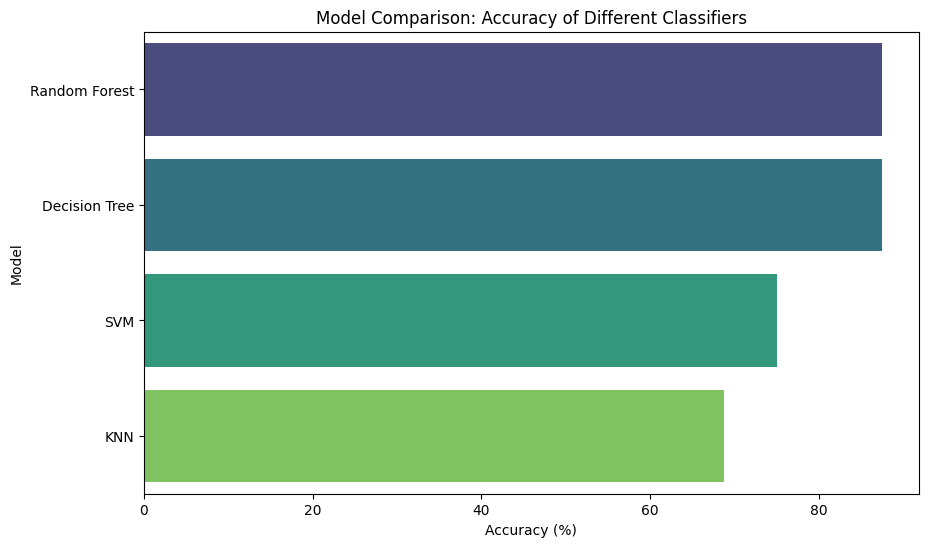

In [19]:

# List of classifiers to compare
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=5),
    "SVM": SVC(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Store the results
results = []

# Split data into training and testing sets (assume X and y are prepared)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Train and evaluate each model
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)  # Train the classifier
    y_pred = clf.predict(X_test)  # Make predictions
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    results.append({"Model": name, "Accuracy": accuracy * 100})

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the results
print("Model Comparison Results:")
print(results_df)

# Plotting the accuracy comparison
plt.figure(figsize=(10, 6))
sns.barplot(x="Accuracy", y="Model", data=results_df, palette="viridis")
plt.title("Model Comparison: Accuracy of Different Classifiers")
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
plt.show()
